In [10]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv
/kaggle/input/nasdaq-stock-tweet-sentiments/stock_tweets.csv


In [11]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


<Figure size 432x288 with 0 Axes>

# Loading the data

In [13]:
df = pd.read_csv('/kaggle/input/nasdaq-stock-tweet-sentiments/stock_tweets.csv',encoding='ISO-8859-1')

NOTE: UTF-8 encoding does not work on the dataset when loading it with pandas 'read_csv' function. This lead to the use of 'ISO-8859-1'/latin-1 encoding. <br>
It will be found later that some special characters like apostrophes are turned into '\x92', which will be taken care of during the data cleaning process.
                                                                                                         

In [14]:
df.head()

,Unnamed: 0,tweet_id,ticker_symbol,writer,body,comment_num,retweet_num,like_num,total_engangement,Date,Sentiment
0,474137,692169663577485315,AAPL,ValaAfshar,Apple has $216 billion in cash. It could buy a...,42,984,677,1703,27-01-2016,Neutral
1,761280,770310550991605760,AAPL,cnntech,Apple's next iPhone will likely be unveiled Se...,11,729,918,1658,29-08-2016,Neutral
2,99172,575014851363405824,AAPL,RANsquawk,Loving my Apple Watch $AAPL,66,882,654,1602,09-03-2015,Positive
3,2752419,816359802733555712,AMZN,DavidSchawel,Sometimes hard to wrap your head around $AMZN,14,646,900,1560,03-01-2017,Negetive
4,2789005,854690001866686464,TSLA,philstockworld,"Will We Hold It Wednesday - Nasdaq 5,400 Editi...",0,969,520,1489,19-04-2017,Neutral


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54440 entries, 0 to 54439
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         54440 non-null  int64 
 1   tweet_id           54440 non-null  int64 
 2   ticker_symbol      54440 non-null  object
 3   writer             53902 non-null  object
 4   body               54440 non-null  object
 5   comment_num        54440 non-null  int64 
 6   retweet_num        54440 non-null  int64 
 7   like_num           54440 non-null  int64 
 8   total_engangement  54440 non-null  int64 
 9   Date               54440 non-null  object
 10  Sentiment          54440 non-null  object
dtypes: int64(6), object(5)
memory usage: 4.6+ MB


We convert the date column 'TweetAt' to pandas datetime format to improve its usability in the further analysis.

In [16]:
df['Date'] = pd.to_datetime(df['Date'])

## Duplicate tweets?

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54440 entries, 0 to 54439
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         54440 non-null  int64         
 1   tweet_id           54440 non-null  int64         
 2   ticker_symbol      54440 non-null  object        
 3   writer             53902 non-null  object        
 4   body               54440 non-null  object        
 5   comment_num        54440 non-null  int64         
 6   retweet_num        54440 non-null  int64         
 7   like_num           54440 non-null  int64         
 8   total_engangement  54440 non-null  int64         
 9   Date               54440 non-null  datetime64[ns]
 10  Sentiment          54440 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 4.6+ MB


# Tweets count by date

In [18]:
df.shape

(54440, 11)

In [19]:
df_test = df.iloc[50000:, :]
df_test.shape

(4440, 11)

In [20]:
df = df.iloc[:50000, :]
df

,Unnamed: 0,tweet_id,ticker_symbol,writer,body,comment_num,retweet_num,like_num,total_engangement,Date,Sentiment
0,474137,692169663577485315,AAPL,ValaAfshar,Apple has $216 billion in cash. It could buy a...,42,984,677,1703,2016-01-27,Neutral
1,761280,770310550991605760,AAPL,cnntech,Apple's next iPhone will likely be unveiled Se...,11,729,918,1658,2016-08-29,Neutral
2,99172,575014851363405824,AAPL,RANsquawk,Loving my Apple Watch $AAPL,66,882,654,1602,2015-09-03,Positive
3,2752419,816359802733555712,AMZN,DavidSchawel,Sometimes hard to wrap your head around $AMZN,14,646,900,1560,2017-03-01,Negetive
4,2789005,854690001866686464,TSLA,philstockworld,"Will We Hold It Wednesday - Nasdaq 5,400 Editi...",0,969,520,1489,2017-04-19,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
49995,3934516,1051943617940590592,TSLA,KawasakiKR11,It's been >100 hrs since this news came out.Ab...,2,8,34,44,2018-10-15,Neutral
49996,3853823,1031513129564266496,TSLA,TeslaOpinion,"Tesla 3 production has a clear path to 8,000 u...",3,10,31,44,2018-08-20,Positive
49997,4079415,1108113068670808064,TSLA,TESLAcharts,The other side of the trade$TSLA,4,0,40,44,2019-03-19,Neutral
49998,3487879,715933108323893248,TSLA,DayTradersGroup,Our $FB Apr16 115.00 calls now @ 2.39 from las...,1,43,0,44,2016-01-04,Neutral


In [21]:
df.shape

(50000, 11)

In [22]:
tweets_per_day = df['Date'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

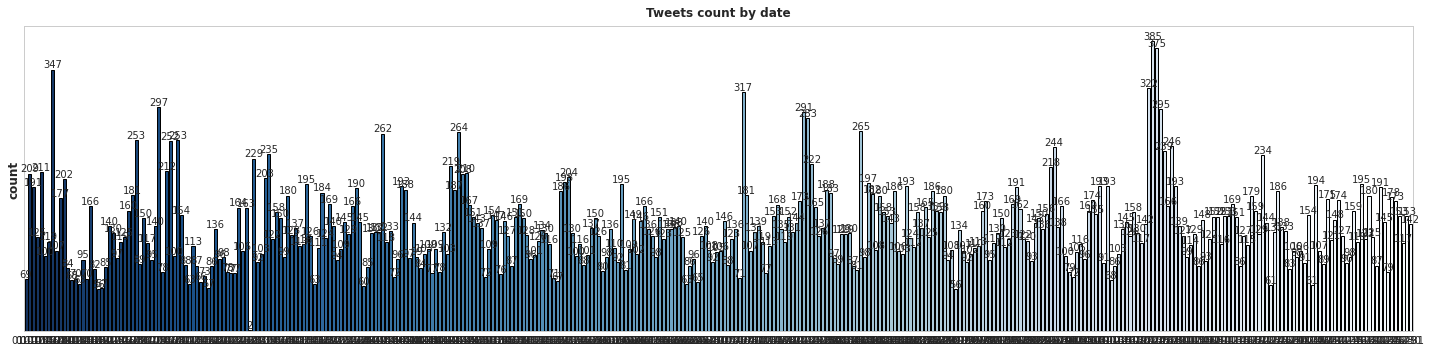

In [23]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

# Tweets Deep Cleaning

In [24]:
df = df[['body','Sentiment']]

In [25]:
df_test = df_test[['body','Sentiment']]

In [26]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [27]:
texts_new = []
for t in df.body:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [28]:
texts_new_test = []
for t in df_test.body:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

Now we can create a new column, for both train and test sets, to host the cleaned version of the tweets' text.

In [29]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
df['text_clean'].head()

0    apple has 216 billion in cash it could buy all...
1    apples next iphone will likely be unveiled sep...
2                           loving my apple watch aapl
3         sometimes hard to wrap your head around amzn
4    will we hold it wednesday nasdaq 5400 edition ...
Name: text_clean, dtype: object

In [31]:
df_test['text_clean'].head()

50000    tsla posts profit of 290sh stock soaring in ah...
50001    amzn bearish engulfing on daily chart is very ...
50002    looking forward to reading filing today on tsl...
50003    ever wonder why tsla cannot supply repair and ...
50004    lets be clear this is what the last big public...
Name: text_clean, dtype: object

In [32]:
df['text_clean'][1:8].values

array(['apples next iphone will likely be unveiled sept 7 via aapl',
       'loving my apple watch aapl',
       'sometimes hard to wrap your head around amzn',
       'will we hold it wednesday nasdaq 5400 edition ndx also qqq sqqq oil uup vix amzn tsla',
       'will we hold it wednesday nasdaq 5400 edition ndx also qqq sqqq oil uup vix amzn tsla',
       'guys im beside myself before you ask this is not a joke i just got off the phone with montana skeptic he told me that he voluntarily deleted his twitter account after elon musk personally called his boss to complain i asked for montanas permission to tweet this tsla',
       'amzn has no stores uber no cars fb creates no content baba no inventory airbnb no real estate bitcoin no currency or coins'],
      dtype=object)

Moreover, we will also create a column to host the lenght of the cleaned text, to check if by cleaning the text we removed too much text or almost entirely the tweet!

In [33]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [34]:
df['text_len'] = text_len

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [36]:
df_test['text_len'] = text_len_test

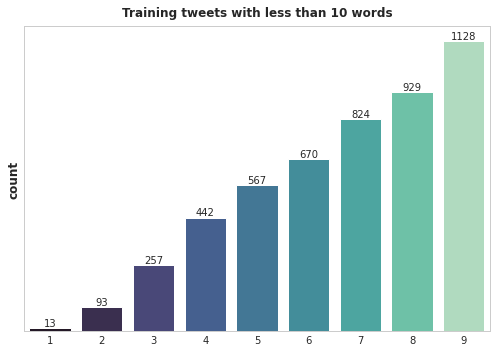

In [37]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

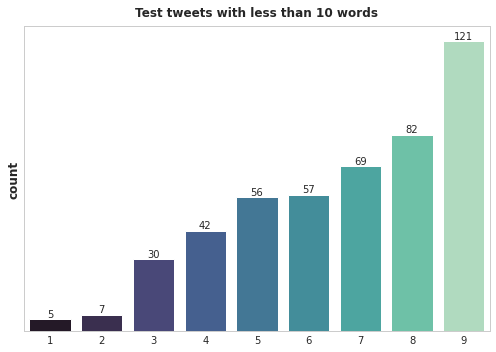

In [38]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

As we can see, there are lots of cleaned tweets with 0 words: this is due to the cleaning performed before. This means that some tweets contained only mentions, hashtags and links, which have been removed. We will drop these empty tweets and also those with less than 5 words.

In [39]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (50000, 4)
 DF TEST SHAPE: (4440, 4)


In [40]:
df = df[df['text_len'] > 4]

In [41]:
df_test = df_test[df_test['text_len'] > 4]

In [42]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (49195, 4)
 DF TEST SHAPE: (4356, 4)


## Training data deeper cleaning

In [43]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [44]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [45]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 114


In [46]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 24, TEXT: earnings for the week amzn aapl amd fb msft baba tsla cat ge ba t pypl vz ups v mcd lmt ma mmm pfe xom mo aks salt algn nue biib nok wynn ebay rtn arlp qcom hog boh glw bx x bmrc sap agn whr siri cvx cade
INDEX: 25, TEXT: earnings for the week amzn aapl amd fb msft baba tsla cat ge ba t pypl vz ups v mcd lmt ma mmm pfe xom mo aks salt algn nue biib nok wynn ebay rtn arlp qcom hog boh glw bx x bmrc sap agn whr siri cvx cade
INDEX: 26, TEXT: earnings for the week amzn aapl amd fb msft baba tsla cat ge ba t pypl vz ups v mcd lmt ma mmm pfe xom mo aks salt algn nue biib nok wynn ebay rtn arlp qcom hog boh glw bx x bmrc sap agn whr siri cvx cade
INDEX: 27, TEXT: earnings for the week amzn aapl amd fb msft baba tsla cat ge ba t pypl vz ups v mcd lmt ma mmm pfe xom mo aks salt algn nue biib nok wynn ebay rtn arlp qcom hog boh glw bx x bmrc sap agn whr siri cvx cade
INDEX: 77, TEXT: earnings msft tsla snap mcd ba hexo twtr pypl pg lmt clf hal v cmg ups cat sap biib intc amtd u

These sentences are not in english. They should be dropped.

In [47]:
df['token_lens'] = token_lens

In [48]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,body,Sentiment,text_clean,text_len,token_lens
3595,TOP20 Company by mkt cap:1 $AAPL 880B2 $GOOGL ...,Neutral,top20 company by mkt cap1 aapl 880b2 googl 821...,45,114
3582,TOP20 Company by mkt cap:1 $AAPL 880B2 $GOOGL ...,Neutral,top20 company by mkt cap1 aapl 880b2 googl 821...,45,114
3592,TOP20 Company by mkt cap:1 $AAPL 880B2 $GOOGL ...,Neutral,top20 company by mkt cap1 aapl 880b2 googl 821...,45,114
12869,TOP20 Tech by mkt cap:1 $AAPL 890B2 $GOOGL 784...,Neutral,top20 tech by mkt cap1 aapl 890b2 googl 784b3 ...,45,111
12904,TOP20 Tech by mkt cap:1 $AAPL 890B2 $GOOGL 784...,Neutral,top20 tech by mkt cap1 aapl 890b2 googl 784b3 ...,45,111
12929,TOP20 Tech by mkt cap:1 $AAPL 890B2 $GOOGL 784...,Neutral,top20 tech by mkt cap1 aapl 890b2 googl 784b3 ...,45,111
12936,TOP20 Tech by mkt cap:1 $AAPL 890B2 $GOOGL 784...,Neutral,top20 tech by mkt cap1 aapl 890b2 googl 784b3 ...,45,111
12942,TOP20 Tech by mkt cap:1 $AAPL 890B2 $GOOGL 784...,Neutral,top20 tech by mkt cap1 aapl 890b2 googl 784b3 ...,45,111
29648,Itâs going to be a BIG week in EarningsLand....,Neutral,its going to be a big week in earningsland buc...,55,98
12903,Earnings $ALGN $AMZN $AQ $BA $BEAT$BIIB $BYD $...,Neutral,earnings algn amzn aq ba beatbiib byd cme cmg ...,41,96


In [49]:
df = df.iloc[12:]
df.head()

,body,Sentiment,text_clean,text_len,token_lens
38506,Mon: $CDNSTues: $UTX $TXN $CMG $IRBTWed: Flash...,Neutral,mon cdnstues utx txn cmg irbtwed flash pmi ba ...,41,95
36888,The Big Kahuna earnings week awaits $AMGN $K...,Positive,the big kahuna earnings week awaits amgn klac ...,53,94
26436,My $TSLA Q2 GAAP loss estimate vs Q1's -$702M:...,Negetive,my tsla q2 gaap loss estimate vs q1s 702mdue t...,48,94
36787,The Big Kahuna earnings week awaits $AMGN $K...,Positive,the big kahuna earnings week awaits amgn klac ...,53,94
20730,"$10,000 Invested 10 years Ago #SP500 #NASDAQ #...",Neutral,10000 invested 10 years ago sp500 nasdaq nyse ...,50,94


The dataset looks more clean now. We will shuffle it and reset the index.

In [50]:
df = df.sample(frac=1).reset_index(drop=True)

## Test data deeper cleaning

We will perform the data cleaning based on the tokenized sentences on the test set.

In [51]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [52]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 87


In [53]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 814, TEXT: pay by mobile you can get ziggurat cryptocurrency winwin amzn ebay meli etsy qvca baba wmt cost tgt kr jpm fb wfc goog snap twtr agn aapl brk crm cmg dis f qqq iep ibm euo vuzi labu enta ccxi htgm cnet tsla
INDEX: 815, TEXT: pay by mobile you can get ziggurat cryptocurrency winwin amzn ebay meli etsy qvca baba wmt cost tgt kr jpm fb wfc goog snap twtr agn aapl brk crm cmg dis f qqq iep ibm euo vuzi labu enta ccxi htgm cnet tsla
INDEX: 817, TEXT: pay by mobile you can get ziggurat cryptocurrency winwin amzn ebay meli etsy qvca baba wmt cost tgt kr jpm fb wfc goog snap twtr agn aapl brk crm cmg dis f qqq iep ibm euo vuzi labu enta ccxi htgm cnet tsla
INDEX: 1113, TEXT: pay by mobile you can get ziggurat cryptocurrency winwin amzn ebay meli etsy qvca baba wmt cost tgt kr jpm fb wfc goog snap twtr agn aapl brk crm cmg dis f qqq iep ibm euo vuzi labu enta ccxi htgm cnet tsla
INDEX: 1349, TEXT: aagc the group holding her back got flushed out today wouldnt be the first or th

In [54]:
df_test['token_lens'] = token_lens_test

In [55]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10) 

,body,Sentiment,text_clean,text_len,token_lens
52469,Pay by mobile. You can get Ziggurat cryptocurr...,Negetive,pay by mobile you can get ziggurat cryptocurre...,43,87
51135,Pay by mobile. You can get Ziggurat cryptocurr...,Negetive,pay by mobile you can get ziggurat cryptocurre...,43,87
50830,Pay by mobile. You can get Ziggurat cryptocurr...,Negetive,pay by mobile you can get ziggurat cryptocurre...,43,87
50831,Pay by mobile. You can get Ziggurat cryptocurr...,Negetive,pay by mobile you can get ziggurat cryptocurre...,43,87
52467,Pay by mobile. You can get Ziggurat cryptocurr...,Negetive,pay by mobile you can get ziggurat cryptocurre...,43,87
50833,Pay by mobile. You can get Ziggurat cryptocurr...,Negetive,pay by mobile you can get ziggurat cryptocurre...,43,87
52473,Pay by mobile. You can get Ziggurat cryptocurr...,Negetive,pay by mobile you can get ziggurat cryptocurre...,43,87
52471,Pay by mobile. You can get Ziggurat cryptocurr...,Negetive,pay by mobile you can get ziggurat cryptocurre...,43,87
54363,#earnings for the week $GOOGL $TWTR $SNAP $CLF...,Neutral,earnings for the week googl twtr snap clf ttwo...,46,86
52482,Pay by mobile. You can get Ziggurat cryptocurr...,Negetive,pay by mobile you can get ziggurat cryptocurre...,43,85


In [57]:
df_test = df_test.iloc[5:]
df_test.head(3)

,body,Sentiment,text_clean,text_len,token_lens
52483,Pay by mobile. You can get Ziggurat cryptocurr...,Negetive,pay by mobile you can get ziggurat cryptocurre...,43,85
52502,Pay by mobile. You can get Ziggurat cryptocurr...,Negetive,pay by mobile you can get ziggurat cryptocurre...,43,85
52485,Pay by mobile. You can get Ziggurat cryptocurr...,Negetive,pay by mobile you can get ziggurat cryptocurre...,43,85


In [58]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

Now the data cleaning is completed. I will perform more data cleaning if I have new ideas !! :)

# Sentiment column analysis

Now we will look at the target column 'Sentiment'.

In [59]:
df['Sentiment'].value_counts()

Positive    21977
Neutral     13829
Negetive    13377
Name: Sentiment, dtype: int64

The first thing we can do is to encode the categories with numbers. We will also create just 3 possible emotions: Positive, Neutral and Negative.

In [60]:
df['Sentiment'] = df['Sentiment'].map({'Negetive':0,'Neutral':1,'Positive':2})

In [61]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Negetive':0,'Neutral':1,'Positive':2})

In [62]:
df['Sentiment'].value_counts()

2    21977
1    13829
0    13377
Name: Sentiment, dtype: int64

We note that the three classes are imbalanced. We will proceed with oversampling the train test, to remove bias towards the majority classes.

## Class Balancing by RandomOverSampler

In [63]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [64]:
train_os['Sentiment'].value_counts()

2    21977
1    21977
0    21977
Name: Sentiment, dtype: int64

## Train - Validation - Test split

In [65]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

A validation set will be extracted from the training set to monitor the validation accuracy, and so prevent overfitting.

In [66]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [67]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

## One hot encoding

After performing some tests, by using one hot encoding on the target variable we achieved higher accuracy. For this reason we will choose one hot enconding over label encoding. <br>
EDIT: We will save a copy of the label encoded target columns since they could be useful for further analysis.

In [68]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [69]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [70]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 59337
VALIDATION DATA: 6594
TESTING DATA: 4346


# BERT Sentiment Analysis

We already performed a basic analyis of the tokenized sentences, now we just need to define a custom tokenizer function and call the encode_plus method of the BERT tokenizer.

In [71]:
MAX_LEN=128

In [72]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Then, we apply the tokenizer function to the train, validation and test sets.

In [73]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

# BERT modeling

Now we can import the BERT model from the pretrained library from Hugging face.

In [74]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Then, we create a custom function to host the pre trained BERT model, and attach to it a 3 neurons output layer, necessary to perform the classification of the 3 different classes of the dataset (the 3 emotions).

In [75]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [76]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 3)            2307        tf_bert_model[0][1]          

Finally we can start fine tuning the BERT transformer !

In [77]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
1855/1855 [==============================] - 921s 489ms/step - loss: 0.4791 - categorical_accuracy: 0.8147 - val_loss: 0.2775 - val_categorical_accuracy: 0.9087
Epoch 2/4
1855/1855 [==============================] - 904s 487ms/step - loss: 0.2259 - categorical_accuracy: 0.9274 - val_loss: 0.2210 - val_categorical_accuracy: 0.9281
Epoch 3/4
1855/1855 [==============================] - 904s 487ms/step - loss: 0.1516 - categorical_accuracy: 0.9516 - val_loss: 0.1937 - val_categorical_accuracy: 0.9416
Epoch 4/4
1855/1855 [==============================] - 904s 487ms/step - loss: 0.1068 - categorical_accuracy: 0.9654 - val_loss: 0.2056 - val_categorical_accuracy: 0.9480


# BERT results

In [78]:
result_bert = model.predict([test_input_ids,test_attention_masks])

In [79]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [80]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.85      0.92      0.88      1186
     Neutral       0.92      0.90      0.91      1262
    Positive       0.93      0.90      0.92      1898

   micro avg       0.90      0.90      0.90      4346
   macro avg       0.90      0.91      0.90      4346
weighted avg       0.91      0.90      0.90      4346
 samples avg       0.90      0.90      0.90      4346



In [82]:
model.save_weights("model.h5")

# Results Summary

## BERT Classification Report

In [83]:
print('Classification Report for BERT:\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report for BERT:
               precision    recall  f1-score   support

    Negative       0.85      0.92      0.88      1186
     Neutral       0.92      0.90      0.91      1262
    Positive       0.93      0.90      0.92      1898

   micro avg       0.90      0.90      0.90      4346
   macro avg       0.90      0.91      0.90      4346
weighted avg       0.91      0.90      0.90      4346
 samples avg       0.90      0.90      0.90      4346

